# Quadruped robot

In this example a simulated IMU is attached to the body of a quadruped robot. We
use [NVIDIA Isaac Sim](https://developer.nvidia.com/isaac/sim) to simulate and
control the robot.  The robot is modeled after the [Boston Dynamics
Spot](https://bostondynamics.com/products/spot/).

![Quadruped Robot](images/quadruped_hero.png)

## Setup

The example runs as an extension in the Isaac Sim UI (see the image above).

The robot is trained to walk on flat terrain using a Reinforcement Learning
approach in [NVIDIA Isaac
Lab](https://docs.isaacsim.omniverse.nvidia.com/latest/robot_simulation/ext_isaacsim_robot_policy_example.html#standalone-examples).
True angular rates and specific forces are available from the simulator and the
IMU (or many IMUs) can be placed anywhere on the robot.  Each IMU and each
simulation run can produce unique and realistic behaviors.  This is an important
enhancement to the overall *domain randomization* of the training environment,
which has been shown to improve the transfer of learned behaviors from
simulation to the real world.

In a training scenario, the robot would be programmatically exposed to tasks of
interest (balancing, walking, climbing, etc).  In this example, the robot is
manually controlled via keyboard input for illustration.  The IMU is simulated
in the loop in `real-time` [mode](../reference/modes.md) as would be required to
allow for feedback in control loops.

## Simulate the robot

The robot is commanded to move through its full range of motions: forward,
backwards, side-stepping, and rotating in place.  Unlike most other examples,
control of the scenario is not via notebook (although that is possible) but via
the Isaac Sim UI.  The result is saved to file and reloaded for analysis here.

<video autoplay loop>
    <source src="../images/quadruped_robot.webm" type="video/webm">
</video>

## Plot simulated measurements

An [Xsens MTi-100][inertialsim.devices.xsens_mti100] IMU is simulated.  Isaac
Sim provides an [IMU
sensor](https://docs.isaacsim.omniverse.nvidia.com/latest/sensors/isaacsim_sensors_physics_imu.html#isaacsim-sensors-physics-imu)
object which collects angular rate and acceleration data from the underlying
physics engine.  It provides a basic moving average filter but no other
simulation options.  This data is provided as the input to the InertialSim IMU
at each physics step in the simulation.

Isaac Sim's default gravity (`9.81 m/s/s`) is modified to match standard gravity
(`9.80665 m/s/s`).

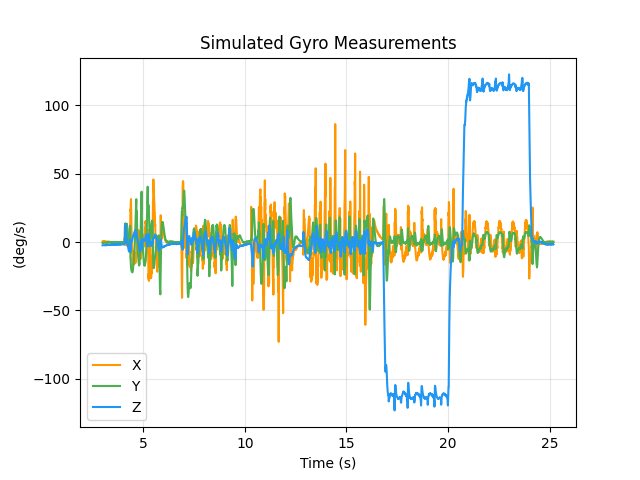

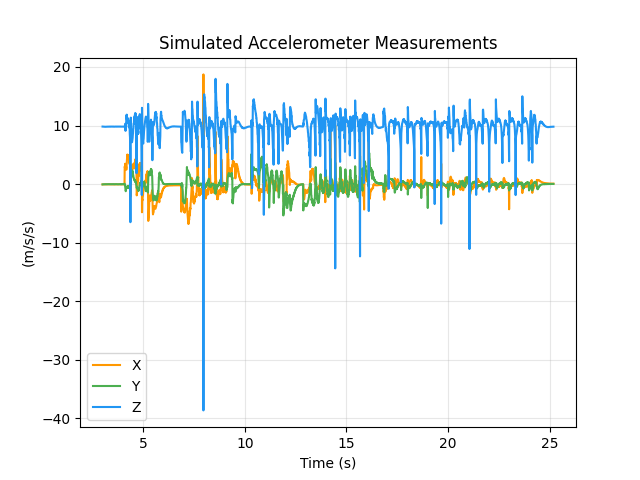

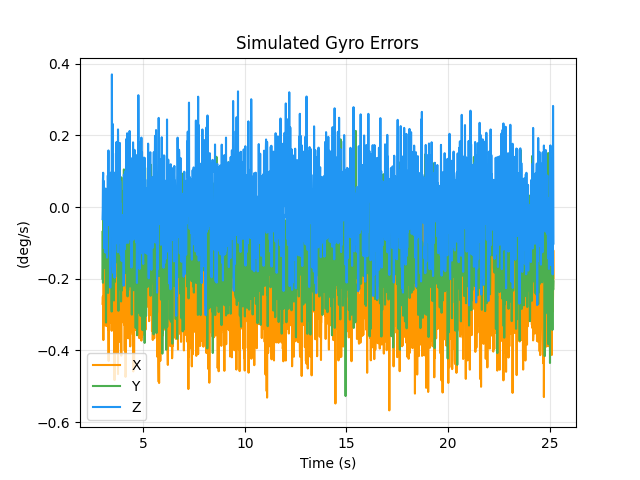

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# This example is licensed under the CC BY-NC-SA 4.0 license.
# https://creativecommons.org/licenses/by-nc-sa/4.0/
# Email: info@inertialsim.com
# -----------------------------------------------------------------------------
%matplotlib widget

import pickle

import numpy as np

from inertialsim import plot
from inertialsim.geometry import Vector
from inertialsim.sensors import Measurement

with open('isaacsim_data/imu_measurements.pkl', 'rb') as file:
    physics, measurements = pickle.load(file)

# Aggregate the Isaac Sim physics variables
time = [p["time"] for p in physics]
true_angular_rate = Vector.from_xyz([p["ang_vel"] for p in physics], time)
true_specific_force = Vector.from_xyz([p["lin_acc"] for p in physics], time)

# Aggregate the InertialSim measurements
angular_rate = Measurement.from_measurements([m.angular_rate for m in measurements])
specific_force = Measurement.from_measurements([m.specific_force for m in measurements])

# Plot gyro data
w_plot = plot.TimeSeries(title="Simulated Gyro Measurements", ylabel="(deg/s)")
w_plot.line(angular_rate.time, np.rad2deg(angular_rate.data))
w_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot accelerometer data
a_plot = plot.TimeSeries(title="Simulated Accelerometer Measurements", ylabel="(m/s/s)")
a_plot.line(specific_force.time, specific_force.data)
a_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot gyro errors
w_plot = plot.TimeSeries(title="Simulated Gyro Errors", ylabel="(deg/s)")
w_plot.line(angular_rate.time, np.rad2deg(angular_rate.data - true_angular_rate.as_xyz()))
w_plot.legend(["X", "Y", "Z"], loc="lower left")

## Analyzing the result

The periodic characteristic of each individual step and each direction of motion
are immediately visible, particularly in the gyro data.  The simulated gyro
errors show the standard characteristics of noise and bias expected for this
class of sensor.  As discussed in [Controlling
determinism](../../reference/determinism/), the user has full control over these
error sources.  Running repeatable simulations is an appropriate strategy for
initial development and for debugging.  Running randomized simulations is state
of the art for AI/ML training.